This is the notebook for my final project in CS 5665 - Introduction to Data Science. The link to the kaggle competition can be found here [INGV - Volcanic Eruption Prediction](https://https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe)

In [1]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from scipy.stats import kurtosis, skew
import scipy.signal

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

import torch
import torch.optim as optim
from torch import nn

## Loading Data

The dataset is ~30 GB. So I decided to download it and place it on my google drive instead of uploading it to google colab each time

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
base_dir = "/content/drive/My Drive/CS 5665/Final Project/data/"

train_file = f"{base_dir}train.csv"
train_dir = f"{base_dir}train/"
test_dir = f"{base_dir}test/"

The training file contains a segment_id and the time_to_eruption. There is a corresponding file in the training directory that matches up to a segment_id and contains 60,001 points over 10 sensors, so a total of 600,010 points per training segment. Any attempt to use the entire dataset would give me memory errors, so all my techniques involve reducing the dimension and extracting useful features

In [4]:
training_labels = pd.read_csv(train_file)
training_labels['segment_id'] = training_labels['segment_id'].astype(str)
training_labels.set_index('segment_id', inplace=True)
training_labels.head()

,time_to_eruption
segment_id,
1136037770,12262005
1969647810,32739612
1895879680,14965999
2068207140,26469720
192955606,31072429


In [5]:
training_segments = glob(f"{train_dir}*.csv")
testing_segments = glob(f"{test_dir}*.csv")
print(f"There are: {len(training_segments)} training files")
print(f"There are: {len(testing_segments)} testing files")

example_file = training_segments[0]
example_df = pd.read_csv(example_file)
print(example_df)

There are: 4431 training files
There are: 4520 testing files
       sensor_1  sensor_2  sensor_3  ...  sensor_8  sensor_9  sensor_10
0          64.0       NaN    -171.0  ...    -522.0     526.0     -239.0
1           0.0       NaN    -165.0  ...    -110.0     411.0        2.0
2         399.0       NaN    -172.0  ...    -131.0     283.0      265.0
3         361.0       NaN    -185.0  ...      29.0     143.0      526.0
4         -27.0       NaN    -153.0  ...     267.0     -14.0      742.0
...         ...       ...       ...  ...       ...       ...        ...
59996      26.0       NaN    -424.0  ...     363.0     344.0      115.0
59997   -1243.0       NaN    -438.0  ...     382.0     333.0     -101.0
59998    -865.0       NaN    -491.0  ...     136.0     352.0     -210.0
59999     -21.0       NaN    -591.0  ...     214.0     343.0     -228.0
60000     911.0       NaN    -592.0  ...    -267.0     313.0     -397.0

[60001 rows x 10 columns]


## Time Domain Feature Extraction

My first attempt is extracting features such as mean, stddev, max, and min from the sensors and trying to predict based on those

### Load time domain features of each signal

In [6]:
def get_time_features(csv_files, label_file=None):
    dataset = []
    labels = []
    ids = []

    for csv_no, csv_file in enumerate(csv_files):
        unique_id = os.path.basename(csv_file).split('.')[0]
        ids.append(unique_id)
        if csv_no % 500 == 0:
            print(f"loaded: {csv_no} files")
        if label_file is not None:
            time_to_eruption = label_file.loc[unique_id].time_to_eruption
            labels.append(time_to_eruption)
        df = pd.read_csv(csv_file)
        df.fillna(0, inplace=True)
        features = []
        for i in df.columns:
            signal = df[i]
            features.append(signal.sum())
            features.append(signal.mean())
            features.append(signal.std())
            features.append(signal.var())
            features.append(signal.max())
            features.append(signal.min())
            features.append(signal.skew())
            features.append(signal.mad())
            features.append(np.quantile(signal, 0.99))
            features.append(np.quantile(signal, 0.75))
            features.append(np.quantile(signal, 0.50))
            features.append(np.quantile(signal, 0.25))
            features.append(np.quantile(signal, 0.01))
        dataset.append(features)
    return np.array(dataset), np.array(labels), np.array(ids)

In [7]:
X, Y, train_ids = get_time_features(training_segments, training_labels)
Y = Y.reshape((-1, 1))
pd.DataFrame(X).to_csv('training_features_time.csv', index=False)
pd.DataFrame(Y).to_csv('training_labels_time.csv', index=False)

test_x, _, test_ids = get_time_features(testing_segments)
pd.DataFrame(test_x).to_csv('testing_features_time.csv', index=False)
pd.DataFrame(test_ids).to_csv('test_ids_time.csv', index=False)

print(X.shape, Y.shape)
print(test_x.shape)

loaded: 0 files
loaded: 500 files
loaded: 1000 files
loaded: 1500 files
loaded: 2000 files
loaded: 2500 files
loaded: 3000 files
loaded: 3500 files
loaded: 4000 files
loaded: 0 files
loaded: 500 files
loaded: 1000 files
loaded: 1500 files
loaded: 2000 files
loaded: 2500 files
loaded: 3000 files
loaded: 3500 files
loaded: 4000 files
loaded: 4500 files
(4431, 130) (4431, 1)
(4520, 130)


Now that we have some features we can work with, lets try a few methods to predict the testing data

In [8]:
train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.2)

### Linear Regression Baseline

In [9]:
reg_time = LinearRegression()
reg_time.fit(train_x, train_y)
train_pred = reg_time.predict(train_x)
val_pred = reg_time.predict(val_x)
lin_train_score_time = np.sqrt(metrics.mean_squared_error(train_y, train_pred))
lin_val_score_time = np.sqrt(metrics.mean_squared_error(val_y, val_pred))

In [10]:
print(f'Root Mean Squared Error Train: {lin_train_score_time}')
print(f'Root Mean Squared Error Validation: {lin_val_score_time}')

Root Mean Squared Error Train: 11560985.433309436
Root Mean Squared Error Validation: 12409603.462650433


### Decision Tree

In [11]:
dec_time = DecisionTreeRegressor()
dec_time.fit(train_x, train_y.ravel())
train_pred = dec_time.predict(train_x)
val_pred = dec_time.predict(val_x)
dt_train_score_time = np.sqrt(metrics.mean_squared_error(train_y, train_pred))
dt_val_score_time = np.sqrt(metrics.mean_squared_error(val_y, val_pred))

In [12]:
print(f'Root Mean Squared Error Train: {dt_train_score_time}')
print(f'Root Mean Squared Error Validation: {dt_val_score_time}')

Root Mean Squared Error Train: 0.0
Root Mean Squared Error Validation: 9930223.200128866


### Random Forest

In [13]:
rf_time = RandomForestRegressor(n_estimators=100)
rf_time.fit(train_x, train_y.ravel())
train_pred = rf_time.predict(train_x)
test_pred = rf_time.predict(test_x)
val_pred = rf_time.predict(val_x)
rf_train_score_time = np.sqrt(metrics.mean_squared_error(train_y, train_pred))
rf_val_score_time = np.sqrt(metrics.mean_squared_error(val_y, val_pred))

In [14]:
print(f'Root Mean Squared Error Train: {rf_train_score_time}')
print(f'Root Mean Squared Error Validation: {rf_val_score_time}')

Root Mean Squared Error Train: 2400037.134389696
Root Mean Squared Error Validation: 6581023.933463447


In [15]:
prediction = pd.concat([pd.DataFrame(test_ids), pd.DataFrame(test_pred)], axis=1)
prediction.to_csv("rf_time.csv", index=False, header=['segment_id', 'time_to_eruption'])

### Deep Neural Network

In [16]:
from torch.utils.data import Dataset, DataLoader

class VolcanoDataset(Dataset):
    def __init__(self, train_features, train_labels):
        super().__init__()
        self.train_features = train_features
        self.train_labels = train_labels

    def __len__(self):
        return len(self.train_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.train_features[idx], self.train_labels[idx])

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.BatchNorm1d(130),
            nn.Linear(130, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, xb):
        xb = self.network(xb)
        return xb

In [18]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [19]:
def train(net, train_features, train_labels, val_features, val_labels,
          num_epochs, learning_rate, batch_size, lr_step=200):
    train_ls, val_ls = [], []
    train_dataset = VolcanoDataset(train_features, train_labels)
    train_iter = DataLoader(train_dataset, batch_size, shuffle=True)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=0.1)   
    criterion = RMSELoss()

    if val_labels is not None:
        min_test_ls = math.inf
        val_features = torch.from_numpy(val_x).float().cuda()
        val_labels = torch.from_numpy(val_y).float().cuda()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_iter:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            yhat = net(X_batch.float())
            loss = criterion(yhat, y_batch.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

        train_ls.append(running_loss / len(train_dataset))
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}: Train loss: {train_ls[-1]}")

        if val_labels is not None:
            with torch.no_grad():
                test_y_hat = net(val_features)
                test_loss = criterion(test_y_hat, val_labels)
                val_ls.append(test_loss)
                if test_loss < min_test_ls:
                    min_test_ls = test_loss
                if epoch % 10 == 0:
                    print(f"Test loss: {val_ls[-1]}, Minimum test loss: {min_test_ls}")
        lr_scheduler.step()

    return train_ls, val_ls

In [20]:
lr = 0.01
batch_size = 32
num_epochs = 250

Epoch: 0: Train loss: 26469527.2234763
Test loss: 26619370.0, Minimum test loss: 26619370.0
Epoch: 10: Train loss: 26273109.69751693
Test loss: 26376246.0, Minimum test loss: 26376246.0
Epoch: 20: Train loss: 25708883.88713318
Test loss: 25798292.0, Minimum test loss: 25798292.0
Epoch: 30: Train loss: 24873540.334085777
Test loss: 24950260.0, Minimum test loss: 24950260.0
Epoch: 40: Train loss: 23881939.88261851
Test loss: 23909218.0, Minimum test loss: 23909218.0
Epoch: 50: Train loss: 22677329.64785553
Test loss: 22679416.0, Minimum test loss: 22679416.0
Epoch: 60: Train loss: 21259490.69074492
Test loss: 21287736.0, Minimum test loss: 21287736.0
Epoch: 70: Train loss: 19728844.38374718
Test loss: 19697972.0, Minimum test loss: 19697972.0
Epoch: 80: Train loss: 18013727.51693002
Test loss: 17959812.0, Minimum test loss: 17959812.0
Epoch: 90: Train loss: 16134683.91422122
Test loss: 16030117.0, Minimum test loss: 16030117.0
Epoch: 100: Train loss: 14229915.083521444
Test loss: 1405146

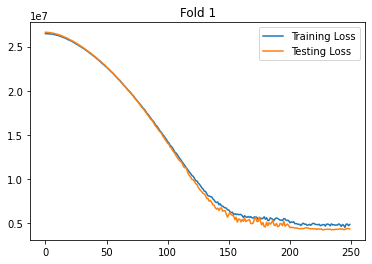

Epoch: 0: Train loss: 26460128.024823695
Test loss: 26619414.0, Minimum test loss: 26619414.0
Epoch: 10: Train loss: 26235676.308039494
Test loss: 26374922.0, Minimum test loss: 26374922.0
Epoch: 20: Train loss: 25670652.462059237
Test loss: 25791592.0, Minimum test loss: 25791592.0
Epoch: 30: Train loss: 24879616.385331452
Test loss: 24967366.0, Minimum test loss: 24967366.0
Epoch: 40: Train loss: 23838402.82538787
Test loss: 23907664.0, Minimum test loss: 23907664.0
Epoch: 50: Train loss: 22621242.735119887
Test loss: 22665106.0, Minimum test loss: 22665106.0
Epoch: 60: Train loss: 21255799.933427364
Test loss: 21250206.0, Minimum test loss: 21250206.0
Epoch: 70: Train loss: 19725233.799153738
Test loss: 19727634.0, Minimum test loss: 19727634.0
Epoch: 80: Train loss: 18020214.797179125
Test loss: 18025998.0, Minimum test loss: 18025998.0
Epoch: 90: Train loss: 16122215.656981664
Test loss: 16116744.0, Minimum test loss: 16116744.0
Epoch: 100: Train loss: 14174390.623695346
Test loss

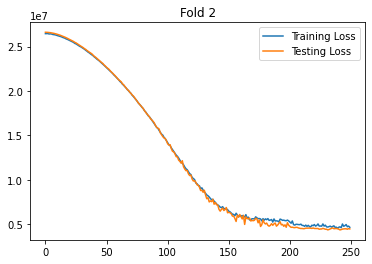

Epoch: 0: Train loss: 26474194.460366715
Test loss: 26619390.0, Minimum test loss: 26619390.0
Epoch: 10: Train loss: 26245945.421720732
Test loss: 26377326.0, Minimum test loss: 26377326.0
Epoch: 20: Train loss: 25674534.594640337
Test loss: 25802718.0, Minimum test loss: 25802718.0
Epoch: 30: Train loss: 24881896.244851906
Test loss: 24967548.0, Minimum test loss: 24967548.0
Epoch: 40: Train loss: 23870028.02651622
Test loss: 23934490.0, Minimum test loss: 23934490.0
Epoch: 50: Train loss: 22665710.15345557
Test loss: 22685414.0, Minimum test loss: 22685414.0
Epoch: 60: Train loss: 21275810.156840622
Test loss: 21278284.0, Minimum test loss: 21278284.0
Epoch: 70: Train loss: 19736186.27306065
Test loss: 19709580.0, Minimum test loss: 19709580.0
Epoch: 80: Train loss: 18046704.471086036
Test loss: 17974608.0, Minimum test loss: 17974608.0
Epoch: 90: Train loss: 16170949.548660085
Test loss: 16161690.0, Minimum test loss: 16161690.0
Epoch: 100: Train loss: 14279122.41100141
Test loss: 1

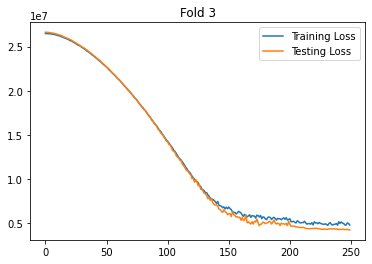

Epoch: 0: Train loss: 26496151.410437234
Test loss: 26619388.0, Minimum test loss: 26619388.0
Epoch: 10: Train loss: 26231303.25528914
Test loss: 26376578.0, Minimum test loss: 26376578.0
Epoch: 20: Train loss: 25707447.5954866
Test loss: 25790418.0, Minimum test loss: 25790418.0
Epoch: 30: Train loss: 24906204.78307475
Test loss: 24974736.0, Minimum test loss: 24974736.0
Epoch: 40: Train loss: 23868536.778561354
Test loss: 23911100.0, Minimum test loss: 23911100.0
Epoch: 50: Train loss: 22642495.241748944
Test loss: 22669998.0, Minimum test loss: 22669998.0
Epoch: 60: Train loss: 21273675.963892806
Test loss: 21249346.0, Minimum test loss: 21249346.0
Epoch: 70: Train loss: 19755060.272496473
Test loss: 19690272.0, Minimum test loss: 19690272.0
Epoch: 80: Train loss: 18033801.412693936
Test loss: 17952834.0, Minimum test loss: 17952834.0
Epoch: 90: Train loss: 16216630.745275036
Test loss: 16026488.0, Minimum test loss: 16026488.0
Epoch: 100: Train loss: 14274041.391819464
Test loss: 1

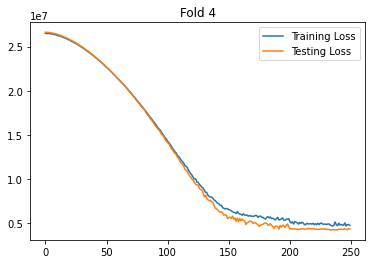

Epoch: 0: Train loss: 26306216.97771509
Test loss: 26619324.0, Minimum test loss: 26619324.0
Epoch: 10: Train loss: 26091061.61748942
Test loss: 26378736.0, Minimum test loss: 26378736.0
Epoch: 20: Train loss: 25549065.89506347
Test loss: 25800452.0, Minimum test loss: 25800452.0
Epoch: 30: Train loss: 24719394.29732017
Test loss: 24984544.0, Minimum test loss: 24984544.0
Epoch: 40: Train loss: 23685012.43667137
Test loss: 23935354.0, Minimum test loss: 23935354.0
Epoch: 50: Train loss: 22491744.6674189
Test loss: 22691448.0, Minimum test loss: 22691448.0
Epoch: 60: Train loss: 21099570.108603667
Test loss: 21285798.0, Minimum test loss: 21285798.0
Epoch: 70: Train loss: 19540044.299576867
Test loss: 19725204.0, Minimum test loss: 19725204.0
Epoch: 80: Train loss: 17877021.492242597
Test loss: 18056238.0, Minimum test loss: 18056238.0
Epoch: 90: Train loss: 16030821.429337094
Test loss: 16158468.0, Minimum test loss: 16158468.0
Epoch: 100: Train loss: 14133446.921861777
Test loss: 1416

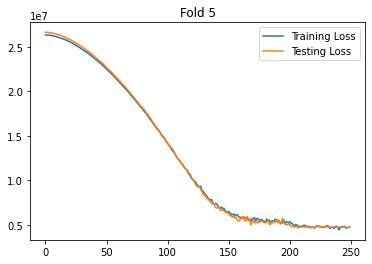

In [21]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
fold_no = 1
avg_val_ls = []
for train_index, test_index, in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    network = MLP().cuda()
    train_ls, val_ls = train(network, X_train, y_train, X_test, y_test, num_epochs, lr, batch_size)
    avg_val_ls.append(val_ls[-1].item())

    plt.title(f"Fold {fold_no}")
    plt.plot(train_ls, label='Training Loss')
    plt.plot(val_ls, label='Testing Loss')
    plt.legend(loc='best', fontsize=10)
    plt.show()
    fold_no += 1
nn_val_score_time = np.mean(avg_val_ls)

In [22]:
network = MLP().cuda()
train_ls, val_ls = train(network, X, Y, None, None, num_epochs, lr, batch_size)

Epoch: 0: Train loss: 26437409.178063642
Epoch: 10: Train loss: 26094271.568946064
Epoch: 20: Train loss: 25277473.55269691
Epoch: 30: Train loss: 24095245.193861432
Epoch: 40: Train loss: 22583882.629203342
Epoch: 50: Train loss: 20845851.817648385
Epoch: 60: Train loss: 18853912.917400137
Epoch: 70: Train loss: 16584508.49921011
Epoch: 80: Train loss: 14176552.064093884
Epoch: 90: Train loss: 11784445.338749718
Epoch: 100: Train loss: 9638317.220943354
Epoch: 110: Train loss: 7758553.634619725
Epoch: 120: Train loss: 6638262.988715866
Epoch: 130: Train loss: 6002099.660347551
Epoch: 140: Train loss: 5687787.0690589035
Epoch: 150: Train loss: 5745216.012638231
Epoch: 160: Train loss: 5519376.417061611
Epoch: 170: Train loss: 5399714.532836831
Epoch: 180: Train loss: 5207657.5379146915
Epoch: 190: Train loss: 5257765.897540059
Epoch: 200: Train loss: 4946849.063191153
Epoch: 210: Train loss: 4887625.053373956
Epoch: 220: Train loss: 4671073.873392011
Epoch: 230: Train loss: 4651873.924

In [23]:
with torch.no_grad():
    preds = network(torch.from_numpy(test_x).float().cuda()).cpu()
    preds = pd.Series(preds.reshape(1, -1)[0], name='time_to_eruption')
    ids = pd.Series(test_ids, name='segment_id')
    submission = pd.concat([ids, preds], axis=1)
    submission.to_csv('nn_time.csv', index=False)

## Frequency Domain Feature Extraction

This method was inpsired by the following notebook: https://www.kaggle.com/amanooo/ingv-volcanic-basic-solution-stft/notebook

The idea is to take the STFT (Short Time Fourier Transform) of each signal. From there we extract the following features


*   Sum of frequencies that are over 10 HZ
*   Sum of frequences that are between 5-8 HZ
*   Sum of frequencies that are between 1.5-2.5 HZ
*   Sum of frequencies between 0.5-1.2 HZ
*   Sum of frequencies between 2-4 HZ





In [24]:
# Total sampling time
t_n = 600

# Total number of data points
N = 60001

# Time between data points
T = t_n / N

# Sampling frequency
f_s = 1 / T

npserseg = 64
max_f = 20 # 20hz
delta_f = f_s / npserseg
delta_t = npserseg / f_s / 2

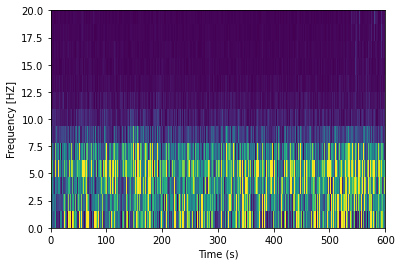

In [25]:
example_file = pd.read_csv(training_segments[0]).fillna(0)

x = example_file['sensor_4'].values
f, t, Z = scipy.signal.stft(x, fs=f_s, window='hann', nperseg=npserseg)
Z = np.abs(Z)
plt.pcolormesh(t, f, Z, vmin=0, vmax=Z.mean() * 10)
plt.ylim(0, 20)
plt.ylabel('Frequency [HZ]')
plt.xlabel('Time (s)')
plt.show()

### Load frequency domain features from each signal

In [26]:
def get_stft_features(csv_files, label_file=None):
    list_of_features = []
    list_of_labels = []
    ids = []

    for csv_no, csv_file in enumerate(csv_files):
        if csv_no % 500 == 0:
            print(f"loaded: {csv_no} files")
        df = pd.read_csv(csv_file)
        unique_id = os.path.basename(csv_file).split('.')[0]
        ids.append(unique_id)
        if label_file is not None:
            time_to_eruption = label_file.loc[unique_id].time_to_eruption
            list_of_labels.append(time_to_eruption)

        features = []
        for sensor in df.columns:
            x = df[sensor][:]
            # Can't extract useful info from sensors that have mostly nan
            if x.isna().sum() > 1000:
                features.extend([0] * 10)
            else:
                x.fillna(0, inplace=True)
                f, t, Z = scipy.signal.stft(x, fs=f_s, window='hann', nperseg=npserseg)

                # Rows represent time, Columns represent frequency
                Z = np.abs(Z[:round(max_f/delta_f)+1]).T

                th = Z.mean()
                Z_pow = Z.copy()
                Z_pow[Z < th] = 0
                Z_num = Z_pow.copy()
                Z_num[Z >= th] = 1

                Z_pow_sum = Z_pow.sum(axis = 0)
                Z_num_sum = Z_num.sum(axis = 0)

                # Get sum of frequencies above 10 HZ
                features.append(Z_pow_sum[round(10/delta_f):].sum())
                features.append(Z_num_sum[round(10/delta_f):].sum())

                # Get sum of frequencies between 5-8 HZ
                features.append(Z_pow_sum[round(5/delta_f):round(8/delta_f)].sum())
                features.append(Z_num_sum[round(5/delta_f):round(8/delta_f)].sum())

                # Get sum of frequencies between 1.5-2.5 HZ
                features.append(Z_pow_sum[round(1.5/delta_f):round(2.5/delta_f)].sum())
                features.append(Z_num_sum[round(1.5/delta_f):round(2.5/delta_f)].sum())

                # Get sum of frequencies between 0.6-1.2 HZ
                features.append(Z_pow_sum[round(0.6/delta_f):round(1.2/delta_f)].sum())
                features.append(Z_num_sum[round(0.6/delta_f):round(1.2/delta_f)].sum())

                # Get sum of frequencies between 2-4 HZ
                features.append(Z_pow_sum[round(2/delta_f):round(4/delta_f)].sum())
                features.append(Z_num_sum[round(2/delta_f):round(4/delta_f)].sum())
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels), np.array(ids)

In [27]:
X, Y, train_ids = get_stft_features(training_segments, training_labels)
Y = Y.reshape((-1, 1))
pd.DataFrame(X).to_csv('training_features_stft.csv', index=False)
pd.DataFrame(Y).to_csv('training_labels_stft.csv', index=False)

test_x, _, test_ids = get_stft_features(testing_segments)
pd.DataFrame(test_x).to_csv('testing_features_stft.csv', index=False)
pd.DataFrame(test_ids).to_csv('test_ids_stft.csv', index=False)

print(X.shape, Y.shape)
print(test_x.shape)

loaded: 0 files
loaded: 500 files
loaded: 1000 files
loaded: 1500 files
loaded: 2000 files
loaded: 2500 files
loaded: 3000 files
loaded: 3500 files
loaded: 4000 files
loaded: 0 files
loaded: 500 files
loaded: 1000 files
loaded: 1500 files
loaded: 2000 files
loaded: 2500 files
loaded: 3000 files
loaded: 3500 files
loaded: 4000 files
loaded: 4500 files
(4431, 100) (4431, 1)
(4520, 100)


In [28]:
train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.2)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(3544, 100) (3544, 1)
(887, 100) (887, 1)


### Linear Regression Baseline

In [29]:
reg_stft = LinearRegression()
reg_stft.fit(train_x, train_y)
train_pred = reg_stft.predict(train_x)
val_pred = reg_stft.predict(val_x)
lin_train_score_stft = np.sqrt(metrics.mean_squared_error(train_y, train_pred))
lin_val_score_stft = np.sqrt(metrics.mean_squared_error(val_y, val_pred))

In [30]:
print(f'Root Mean Squared Error Train: {lin_train_score_stft}')
print(f'Root Mean Squared Error Validation: {lin_val_score_stft}')

Root Mean Squared Error Train: 9133932.756132472
Root Mean Squared Error Validation: 9986394.436401863


### Decision Tree

In [31]:
dec_stft = DecisionTreeRegressor()
dec_stft.fit(train_x, train_y.ravel())
train_pred = dec_stft.predict(train_x)
val_pred = dec_stft.predict(val_x)
dt_train_score_stft = np.sqrt(metrics.mean_squared_error(train_y, train_pred))
dt_val_score_stft = np.sqrt(metrics.mean_squared_error(val_y, val_pred))

In [32]:
print(f'Root Mean Squared Error Train: {dt_train_score_stft}')
print(f'Root Mean Squared Error Validation: {dt_val_score_stft}')

Root Mean Squared Error Train: 0.0
Root Mean Squared Error Validation: 7769079.72694672


### Random Forest

In [33]:
rf_stft = RandomForestRegressor(n_estimators=100)
rf_stft.fit(train_x, train_y.ravel())
train_pred = rf_stft.predict(train_x)
test_pred = rf_stft.predict(test_x)
val_pred = rf_stft.predict(val_x)
rf_train_score_stft = np.sqrt(metrics.mean_squared_error(train_y, train_pred))
rf_val_score_stft = np.sqrt(metrics.mean_squared_error(val_y, val_pred))

In [34]:
print('Root Mean Squared Error Train:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Root Mean Squared Error Validation:', np.sqrt(metrics.mean_squared_error(val_y, val_pred)))

Root Mean Squared Error Train: 1666703.6931764493
Root Mean Squared Error Validation: 4398938.783061467


In [35]:
prediction = pd.concat([pd.DataFrame(test_ids), pd.DataFrame(test_pred)], axis=1)
prediction.to_csv("rf_stft.csv", index=False, header=['segment_id', 'time_to_eruption'])

### Deep Neural Network

In [36]:
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.BatchNorm1d(100),
            nn.Linear(100, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
        )

    def forward(self, xb):
        xb = self.network(xb)
        return xb

In [37]:
lr = 0.005
batch_size = 32
num_epochs = 500
lr_step = 500

Epoch: 0: Train loss: 26490833.661399547
Test loss: 26496006.0, Minimum test loss: 26496006.0
Epoch: 10: Train loss: 26376334.126410834
Test loss: 26376464.0, Minimum test loss: 26376464.0
Epoch: 20: Train loss: 26100492.496613994
Test loss: 26097902.0, Minimum test loss: 26097902.0
Epoch: 30: Train loss: 25713076.677200902
Test loss: 25696410.0, Minimum test loss: 25696410.0
Epoch: 40: Train loss: 25222731.15575621
Test loss: 25190286.0, Minimum test loss: 25190286.0
Epoch: 50: Train loss: 24614980.076749437
Test loss: 24593416.0, Minimum test loss: 24593416.0
Epoch: 60: Train loss: 23920981.8013544
Test loss: 23901404.0, Minimum test loss: 23901404.0
Epoch: 70: Train loss: 23157919.237020317
Test loss: 23137724.0, Minimum test loss: 23137724.0
Epoch: 80: Train loss: 22296150.23476298
Test loss: 22256840.0, Minimum test loss: 22256840.0
Epoch: 90: Train loss: 21364156.50564334
Test loss: 21305610.0, Minimum test loss: 21305610.0
Epoch: 100: Train loss: 20322437.304740407
Test loss: 20

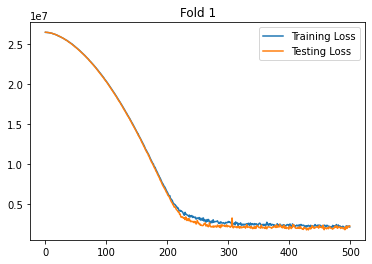

Epoch: 0: Train loss: 26450351.65416079
Test loss: 26495986.0, Minimum test loss: 26495986.0
Epoch: 10: Train loss: 26345229.471368123
Test loss: 26376544.0, Minimum test loss: 26376544.0
Epoch: 20: Train loss: 26073022.195204515
Test loss: 26095700.0, Minimum test loss: 26095700.0
Epoch: 30: Train loss: 25673835.194922425
Test loss: 25699810.0, Minimum test loss: 25699810.0
Epoch: 40: Train loss: 25169139.770944994
Test loss: 25192878.0, Minimum test loss: 25192878.0
Epoch: 50: Train loss: 24593213.23779972
Test loss: 24588766.0, Minimum test loss: 24588766.0
Epoch: 60: Train loss: 23908896.527503528
Test loss: 23907398.0, Minimum test loss: 23907398.0
Epoch: 70: Train loss: 23140576.362200283
Test loss: 23125292.0, Minimum test loss: 23125292.0
Epoch: 80: Train loss: 22268402.740761638
Test loss: 22256176.0, Minimum test loss: 22256176.0
Epoch: 90: Train loss: 21341412.117912553
Test loss: 21312886.0, Minimum test loss: 21312886.0
Epoch: 100: Train loss: 20310353.851057827
Test loss:

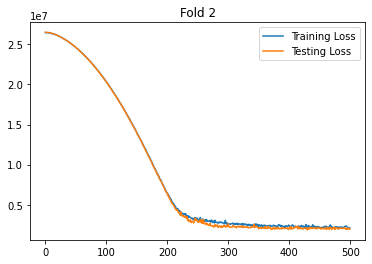

Epoch: 0: Train loss: 26477093.636671368
Test loss: 26496040.0, Minimum test loss: 26496040.0
Epoch: 10: Train loss: 26343312.75937941
Test loss: 26375960.0, Minimum test loss: 26375960.0
Epoch: 20: Train loss: 26078101.212976024
Test loss: 26098266.0, Minimum test loss: 26098266.0
Epoch: 30: Train loss: 25689091.118758816
Test loss: 25695658.0, Minimum test loss: 25695658.0
Epoch: 40: Train loss: 25175327.77771509
Test loss: 25198244.0, Minimum test loss: 25198244.0
Epoch: 50: Train loss: 24608188.005077574
Test loss: 24581886.0, Minimum test loss: 24581886.0
Epoch: 60: Train loss: 23916651.524400566
Test loss: 23910738.0, Minimum test loss: 23910738.0
Epoch: 70: Train loss: 23158620.147249646
Test loss: 23127122.0, Minimum test loss: 23127122.0
Epoch: 80: Train loss: 22301218.805641748
Test loss: 22244912.0, Minimum test loss: 22244912.0
Epoch: 90: Train loss: 21341363.63554302
Test loss: 21317388.0, Minimum test loss: 21317388.0
Epoch: 100: Train loss: 20332462.21551481
Test loss: 2

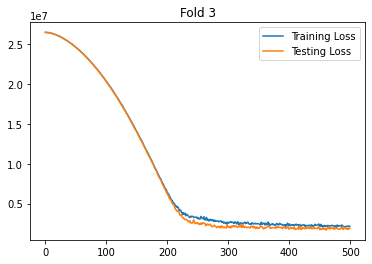

Epoch: 0: Train loss: 26490924.934273627
Test loss: 26496006.0, Minimum test loss: 26496006.0
Epoch: 10: Train loss: 26368084.927503526
Test loss: 26376242.0, Minimum test loss: 26376242.0
Epoch: 20: Train loss: 26118341.231593795
Test loss: 26097556.0, Minimum test loss: 26097556.0
Epoch: 30: Train loss: 25708481.060648803
Test loss: 25698702.0, Minimum test loss: 25698702.0
Epoch: 40: Train loss: 25210617.84767278
Test loss: 25189342.0, Minimum test loss: 25189342.0
Epoch: 50: Train loss: 24604618.498730607
Test loss: 24590022.0, Minimum test loss: 24590022.0
Epoch: 60: Train loss: 23931217.8764457
Test loss: 23901144.0, Minimum test loss: 23901144.0
Epoch: 70: Train loss: 23156503.821156558
Test loss: 23124838.0, Minimum test loss: 23124838.0
Epoch: 80: Train loss: 22304244.81015515
Test loss: 22262636.0, Minimum test loss: 22262636.0
Epoch: 90: Train loss: 21362238.17150917
Test loss: 21302398.0, Minimum test loss: 21302398.0
Epoch: 100: Train loss: 20339952.684344146
Test loss: 20

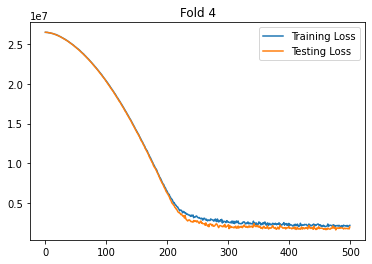

Epoch: 0: Train loss: 26294741.1977433
Test loss: 26496002.0, Minimum test loss: 26496002.0
Epoch: 10: Train loss: 26187420.784203105
Test loss: 26376118.0, Minimum test loss: 26376118.0
Epoch: 20: Train loss: 25919559.38222849
Test loss: 26098072.0, Minimum test loss: 26098072.0
Epoch: 30: Train loss: 25509568.260648802
Test loss: 25696774.0, Minimum test loss: 25696774.0
Epoch: 40: Train loss: 25029576.90493653
Test loss: 25190368.0, Minimum test loss: 25190368.0
Epoch: 50: Train loss: 24452311.943018336
Test loss: 24593170.0, Minimum test loss: 24593170.0
Epoch: 60: Train loss: 23758227.92609309
Test loss: 23897626.0, Minimum test loss: 23897626.0
Epoch: 70: Train loss: 22977494.34922426
Test loss: 23138256.0, Minimum test loss: 23138256.0
Epoch: 80: Train loss: 22135691.84428773
Test loss: 22273118.0, Minimum test loss: 22273118.0
Epoch: 90: Train loss: 21208811.202820875
Test loss: 21322076.0, Minimum test loss: 21322076.0
Epoch: 100: Train loss: 20153835.305500705
Test loss: 2026

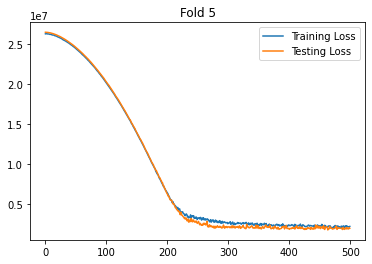

In [38]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
fold_no = 1
avg_val_ls = []
for train_index, test_index, in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    network = MLP2().cuda()
    train_ls, val_ls = train(network, X_train, y_train, X_test, y_test, num_epochs, lr, batch_size, lr_step)
    avg_val_ls.append(val_ls[-1].item())

    plt.title(f"Fold {fold_no}")
    plt.plot(train_ls, label='Training Loss')
    plt.plot(val_ls, label='Testing Loss')
    plt.legend(loc='best', fontsize=10)
    plt.show()
    fold_no += 1
nn_val_score_stft = np.mean(avg_val_ls)

In [39]:
network = MLP2().cuda()
train_ls, val_ls = train(network, X, Y, None, None, num_epochs, lr, batch_size, lr_step)

Epoch: 0: Train loss: 26458719.746332657
Epoch: 10: Train loss: 26274420.635522455
Epoch: 20: Train loss: 25866459.002933875
Epoch: 30: Train loss: 25288879.67185737
Epoch: 40: Train loss: 24570190.68878357
Epoch: 50: Train loss: 23691695.344166104
Epoch: 60: Train loss: 22685143.54863462
Epoch: 70: Train loss: 21556315.80365606
Epoch: 80: Train loss: 20268257.04942451
Epoch: 90: Train loss: 18863220.97404649
Epoch: 100: Train loss: 17336722.38772286
Epoch: 110: Train loss: 15692317.280974949
Epoch: 120: Train loss: 13948165.016249154
Epoch: 130: Train loss: 12087786.298352517
Epoch: 140: Train loss: 10159097.127962084
Epoch: 150: Train loss: 8194292.485894832
Epoch: 160: Train loss: 6435777.202663056
Epoch: 170: Train loss: 4880408.096197247
Epoch: 180: Train loss: 3898380.4542428344
Epoch: 190: Train loss: 3520743.9733694424
Epoch: 200: Train loss: 3200035.458812909
Epoch: 210: Train loss: 3198131.9787294064
Epoch: 220: Train loss: 2964812.340103814
Epoch: 230: Train loss: 2859649.82

In [40]:
with torch.no_grad():
    preds = network(torch.from_numpy(test_x).float().cuda()).cpu()
    preds = pd.Series(preds.reshape(1, -1)[0], name='time_to_eruption')
    ids = pd.Series(test_ids, name='segment_id')
    submission = pd.concat([ids, preds], axis=1)
    submission.to_csv('nn_stft.csv', index=False)

## Comparing Results of validation data

In [41]:
d = {
    'Time Domain Linear Regression': lin_val_score_time,
    'Time Domain Decision Tree': dt_val_score_time,
    'Time Domain Random Forest': rf_val_score_time,
    'Time Domain Neural Network': nn_val_score_time,
    'Frequency Domain Linear Regression': lin_val_score_stft,
    'Frequency Domain Decision Tree': dt_val_score_stft,
    'Frequency Domain Random Forest': rf_val_score_stft,
    'Frequency Domain Neural Network': nn_val_score_stft
}
sorted_keys = sorted(d, key=d.get) 

In [42]:
for key in sorted_keys:
    print(f"{key}: {d[key]}")

Frequency Domain Neural Network: 2006641.4
Frequency Domain Random Forest: 4398938.783061467
Time Domain Neural Network: 4449510.4
Time Domain Random Forest: 6581023.933463447
Frequency Domain Decision Tree: 7769079.72694672
Time Domain Decision Tree: 9930223.200128866
Frequency Domain Linear Regression: 9986394.436401863
Time Domain Linear Regression: 12409603.462650433


Looks like the best results come from using the neural network in the frequency domain.